# Søndag (30.03.25)

In [1]:
import requests # library for making HTTP requests
import pandas as pd # library for data analysis
import datetime as dt # library for handling date and time objects
import json # library for working with JSON data
import numpy as np # library for numerical computing
import time
import requests
from datetime import timedelta # library for manipulating date and time
from concurrent.futures import ThreadPoolExecutor, as_completed

import requests
import pandas as pd
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


In [2]:
api_key = 'd111ba1d-a1f5-43a5-98c6-347e9c2729b2'
DMI_URL_OBS = 'https://dmigw.govcloud.dk/v2/metObs/collections/observation/items'
DMI_URL_STATION = 'https://dmigw.govcloud.dk/v2/metObs/collections/station/items'
MAX_WORKERS = 5  # Limit concurrent requests to avoid API throttling
#r = requests.get(DMI_URL_OBS, params={'api-key': api_key}) # Issues a HTTP GET request
#print(r)

# PARAMETER DESCRIPTIONS AT:
# https://opendatadocs.dmi.govcloud.dk/en/Data/Meteorological_Observation_Data

Inkluderer kun vejrstationer i denne kasse: <br>
![Screenshot 2025-03-31 at 09.09.24.png](<attachment:Screenshot 2025-03-31 at 09.09.24.png>)
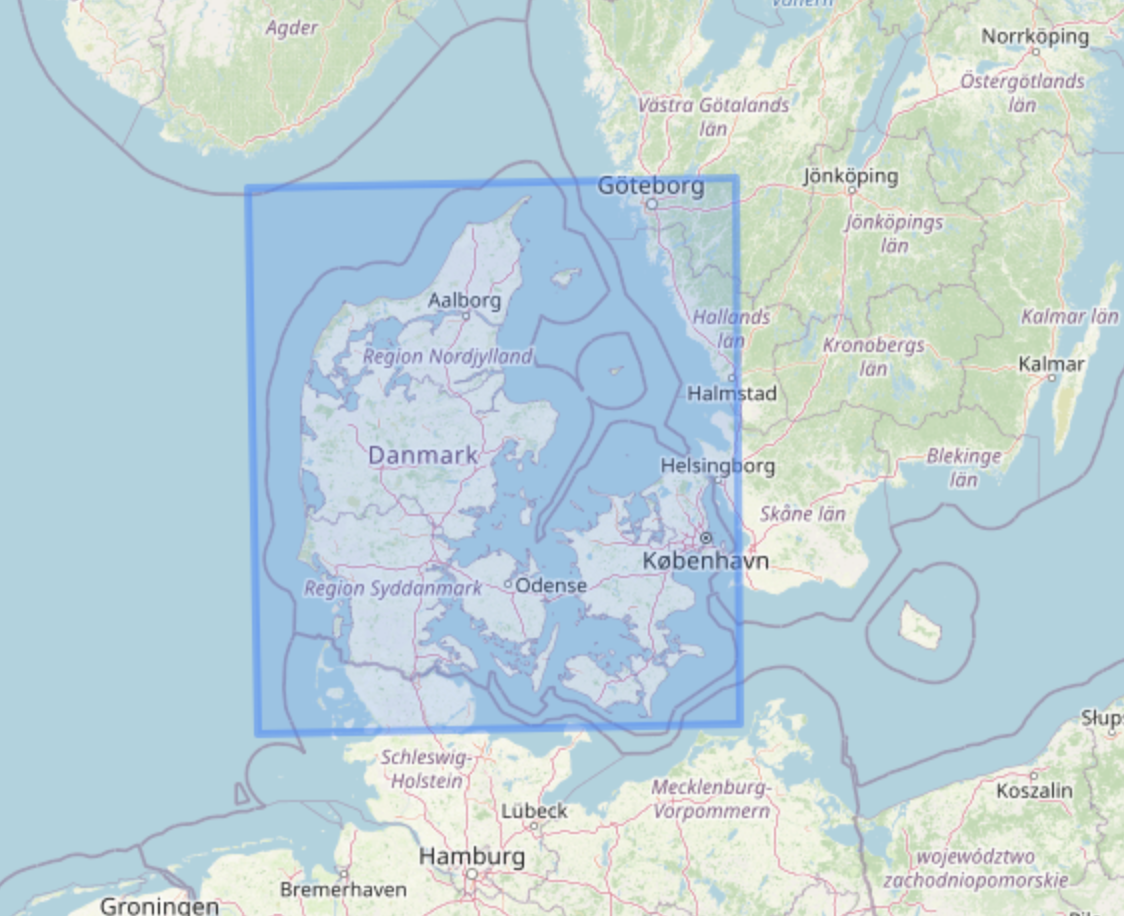

In [3]:
# Get the list of all available stations
r = requests.get(DMI_URL_STATION, params={'api-key': api_key}, timeout=30)
json_data = r.json()

# Convert to DataFrame and clean column names in one step
stations = pd.json_normalize(json_data['features'])
stations.columns = [c.replace('properties.', '').replace('geometry.', '') for c in stations.columns]
 
# Filtering out stations not between certain latitude and longitude
# upper left: lat: 57.809651 long: 7.253075
# lower right: lat: 54.303704 long: 13.321548
stations = stations[(stations['coordinates'].apply(lambda x: x[1]) > 54.303704) &
                    (stations['coordinates'].apply(lambda x: x[1]) < 57.809651) &
                    (stations['coordinates'].apply(lambda x: x[0]) > 7.253075) &
                    (stations['coordinates'].apply(lambda x: x[0]) < 13.321548)]

# Filter for active stations with current locations in one step
stations = stations[(stations['status'] == 'Active') & (stations['validTo'].isna())]

# Filter for Danish stations
stations_DK = stations[stations['country'] == 'DNK']
stationIds_DK = stations_DK['stationId'].tolist()

# Extract unique parameters more efficiently
all_params = []
for feature in json_data['features']:
    param = feature['properties'].get('parameterId', [])
    if isinstance(param, list):
        all_params.extend(param)
    elif param:
        all_params.append(param)
        
parameterIds = sorted(list(set(all_params)))

# Print results
print(f"All parameters ({len(parameterIds)}): {parameterIds}")
print(f"Parameters in Danish stations ({len(parameterIds)}): {parameterIds}")
print(f"All station IDs ({len(stationIds_DK)}): {stationIds_DK}")
print(f"Total stations: {len(stations)}")
print(f"Danish stations: {len(stations_DK)}")
print(f"Greenlandic and Faroese stations: {len(stations) - len(stations_DK)}")

All parameters (47): ['cloud_cover', 'cloud_height', 'humidity', 'humidity_past1h', 'leav_hum_dur_past10min', 'leav_hum_dur_past1h', 'precip_dur_past10min', 'precip_dur_past1h', 'precip_past10min', 'precip_past1h', 'precip_past1min', 'precip_past24h', 'pressure', 'pressure_at_sea', 'radia_glob', 'radia_glob_past1h', 'snow_cover_man', 'snow_depth_man', 'sun_last10min_glob', 'sun_last1h_glob', 'temp_dew', 'temp_dry', 'temp_grass', 'temp_grass_max_past1h', 'temp_grass_mean_past1h', 'temp_grass_min_past1h', 'temp_max_past12h', 'temp_max_past1h', 'temp_mean_past1h', 'temp_min_past12h', 'temp_min_past1h', 'temp_soil', 'temp_soil_max_past1h', 'temp_soil_mean_past1h', 'temp_soil_min_past1h', 'visib_mean_last10min', 'visibility', 'weather', 'wind_dir', 'wind_dir_past1h', 'wind_gust_always_past1h', 'wind_max', 'wind_max_per10min_past1h', 'wind_min', 'wind_min_past1h', 'wind_speed', 'wind_speed_past1h']
Parameters in Danish stations (47): ['cloud_cover', 'cloud_height', 'humidity', 'humidity_past

# Lort (fold sammen)

In [ ]:
stations_DK.sort_values(by='operationFrom', inplace=True)
# Summing stations in a new DataFrame by operationFrom year
stations_DK['operationYear'] = pd.to_datetime(stations_DK['operationFrom']).dt.year
stations_summary = stations_DK.groupby('operationYear').size().reset_index(name='stationCount')

# Display the summary
print(stations_summary)

In [ ]:
import requests
import pandas as pd

def find_earliest_date(stationId, parameterId, api_key, DMI_URL):
    start_year = 1937
    end_time = pd.Timestamp.now().tz_localize('UTC').isoformat()
    earliest_date = None
    
    while start_year <= pd.Timestamp.now().year:
        datetime_str = f"{start_year}-01-01T00:00:00Z/{end_time}"
        params = {
            'api-key': api_key,
            'datetime': datetime_str,
            'stationId': stationId,
            'parameterId': parameterId,
            'limit': '300000'
        }
        
        r = requests.get(DMI_URL, params=params)
        times = [pd.to_datetime(f['properties']['observed']) for f in r.json().get('features', [])]
        
        if times:
            current_min = min(times)
            if earliest_date is None or current_min < earliest_date:
                earliest_date = current_min
            break  # Once we find data, we can stop searching
        
        start_year += 1
    
    if earliest_date:
        print(earliest_date)
    else:
        print("No data found")
    
    return earliest_date  # Return the value as well for potential further use

# Example usage
find_earliest_date('26345', 'weather', api_key, DMI_URL_STATION)

In [ ]:

def fetch_station_parameter_data(station, parameter, start_time, end_time, api_key):
    """
    Fetch data for a specific station and parameter combination.
    
    Args:
        station (str): Station ID
        parameter (str): Parameter ID
        start_time (pd.Timestamp): Start time
        end_time (pd.Timestamp): End time
        api_key (str): API key
        
    Returns:
        pd.DataFrame or None: Processed dataframe for this station/parameter or None if no data
    """
    datetime_str = start_time.tz_localize('UTC').isoformat() + '/' + end_time.tz_localize('UTC').isoformat()
    
    params = {
        'api-key': api_key,
        'datetime': datetime_str,
        'stationId': station,
        'parameterId': parameter,
        'limit': '300000',  # Max limit
    }
    
    try:
        logger.info(f"Fetching data for station {station}, parameter {parameter}")
        r = requests.get(DMI_URL_OBS, params=params, timeout=30)
        
        logger.info(f"Station {station}, parameter {parameter}: HTTP {r.status_code}")
        
        if r.status_code != 200:
            logger.warning(f"Request failed with HTTP {r.status_code} for station {station}, parameter {parameter}")
            return None
        
        json_data = r.json()
        df = pd.json_normalize(json_data['features'])
        
        if df.empty:
            logger.info(f"No data found for station {station}, parameter {parameter}")
            return None
        
        df['time'] = pd.to_datetime(df['properties.observed'])
        df = df[['time', 'properties.value', 'properties.stationId', 'properties.parameterId']]
        df.columns = [c.replace('properties.', '') for c in df.columns]
        df = df[~df.duplicated()]
        
        df = df.set_index(['parameterId', 'stationId', 'time'])
        df = df['value'].unstack(['stationId', 'parameterId'])
        
        #logger.info(f"Retrieved {len(df)} records for station {station}, parameter {parameter}")
        return df
        
    except requests.exceptions.RequestException as e:
        logger.error(f"Request error for station {station}, parameter {parameter}: {e}")
        return None
    except Exception as e:
        logger.error(f"Unexpected error for station {station}, parameter {parameter}: {e}")
        return None

In [ ]:
import pandas as pd
import requests

def find_earliest_date(station, parameter, api_key, low=pd.Timestamp('1900-01-01'), high=pd.Timestamp.now()):
    """
    Find the earliest date with data for a given station and parameter using binary search.
    
    Parameters:
    - station (str): Station ID, e.g., '04250'
    - parameter (str): Parameter ID, e.g., 'temp_mean_past1h'
    - api_key (str): Your API key
    - low (pd.Timestamp): Earliest possible date (default: 1900-01-01)
    - high (pd.Timestamp): Latest possible date (default: now)
    
    Returns:
    - pd.Timestamp: Earliest date with data
    """
    while low < high:
        mid = low + (high - low) // 2
        end_mid = mid + pd.Timedelta(days=1)
        # Fetch data for a 1-day range starting at mid
        df = fetch_station_parameter_data(station, parameter, mid, end_mid, api_key)
        if df is not None and not df.empty:
            # Data exists, search earlier dates
            high = mid
        else:
            # No data, search later dates
            low = mid + pd.Timedelta(days=1)
    return low

# Example usage
api_key = api_key
station = "20375"
parameter = "precip_past24h"
earliest_date = find_earliest_date(station, parameter, api_key)
print(f"The earliest data entry for station {station} and parameter {parameter} is on {earliest_date}")

In [ ]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Constants
DMI_URL_OBS = 'https://dmigw.govcloud.dk/v2/metObs/collections/observation/items'

def find_earliest_datapoint(station_id, parameter_id, api_key, max_age_years=10):
    """
    Find the earliest available datapoint for a station and parameter.
    Uses a binary search approach to efficiently find the start date.
    
    Args:
        station_id (str): Station ID
        parameter_id (str): Parameter ID
        api_key (str): API key
        max_age_years (int): Maximum age to search in years
        
    Returns:
        pd.Timestamp or None: Timestamp of earliest datapoint or None if not found
    """
    logger.info(f"Finding earliest datapoint for station {station_id}, parameter {parameter_id}")
    
    # Start with current date
    end_date = pd.Timestamp.now()
    
    # Set the earliest date to search (default 10 years ago)
    start_date = end_date - pd.Timedelta(days=365 * max_age_years)
    
    # Check if any data exists within the maximum time range
    if not has_data_in_range(station_id, parameter_id, start_date, end_date, api_key):
        logger.info(f"No data found for station {station_id}, parameter {parameter_id} in the last {max_age_years} years")
        return None
    
    # Binary search to find the earliest datapoint
    earliest_with_data = end_date
    
    while (end_date - start_date).days > 7:  # Stop when we're within a week
        mid_date = start_date + (end_date - start_date) / 2
        
        logger.info(f"Checking range: {start_date.date()} to {mid_date.date()}")
        
        if has_data_in_range(station_id, parameter_id, start_date, mid_date, api_key):
            # Data exists in the first half, update the end pointer
            end_date = mid_date
            earliest_with_data = end_date
        else:
            # No data in the first half, update the start pointer
            start_date = mid_date
    
    # Final precise check - search day by day within the final week
    precise_start = max(start_date - pd.Timedelta(days=7), start_date)
    
    for days in range((end_date - precise_start).days + 1):
        check_date = precise_start + pd.Timedelta(days=days)
        next_date = check_date + pd.Timedelta(days=1)
        
        if has_data_in_range(station_id, parameter_id, check_date, next_date, api_key):
            # Find the exact timestamp of the first datapoint
            first_record = get_first_record(station_id, parameter_id, check_date, next_date, api_key)
            if first_record:
                logger.info(f"Found earliest datapoint at {first_record}")
                return first_record
    
    logger.info(f"Earliest data found around {earliest_with_data.date()}")
    return earliest_with_data

def has_data_in_range(station_id, parameter_id, start_time, end_time, api_key):
    """
    Check if there is any data available in the given time range.
    
    Args:
        station_id (str): Station ID
        parameter_id (str): Parameter ID
        start_time (pd.Timestamp): Start time
        end_time (pd.Timestamp): End time
        api_key (str): API key
        
    Returns:
        bool: True if data exists, False otherwise
    """
    # Format datetime string
    datetime_str = start_time.tz_localize('UTC').isoformat() + '/' + end_time.tz_localize('UTC').isoformat()
    
    # Set up parameters
    params = {
        'api-key': api_key,
        'datetime': datetime_str,
        'stationId': station_id,
        'parameterId': parameter_id,
        'limit': '1'  # We only need to know if any data exists
    }
    
    try:
        # Make the request
        response = requests.get(DMI_URL_OBS, params=params, timeout=15)
        
        if response.status_code != 200:
            logger.warning(f"Request failed with HTTP {response.status_code}")
            return False
        
        # Parse the response
        json_data = response.json()
        features = json_data.get('features', [])
        
        # Return True if there's at least one datapoint
        return len(features) > 0
        
    except Exception as e:
        logger.error(f"Error checking data range: {e}")
        return False

def get_first_record(station_id, parameter_id, start_time, end_time, api_key):
    """
    Get the timestamp of the first record in the given time range.
    
    Args:
        station_id (str): Station ID
        parameter_id (str): Parameter ID
        start_time (pd.Timestamp): Start time
        end_time (pd.Timestamp): End time
        api_key (str): API key
        
    Returns:
        pd.Timestamp or None: Timestamp of first record or None if not found
    """
    # Format datetime string
    datetime_str = start_time.tz_localize('UTC').isoformat() + '/' + end_time.tz_localize('UTC').isoformat()
    
    # Set up parameters
    params = {
        'api-key': api_key,
        'datetime': datetime_str,
        'stationId': station_id,
        'parameterId': parameter_id,
        'limit': '1',
        'sortby': 'observed',  # Sort by observation time
        'sortorder': 'asc'     # Ascending order to get earliest first
    }
    
    try:
        # Make the request
        response = requests.get(DMI_URL_OBS, params=params, timeout=15)
        
        if response.status_code != 200:
            logger.warning(f"Request failed with HTTP {response.status_code}")
            return None
        
        # Parse the response
        json_data = response.json()
        features = json_data.get('features', [])
        
        if not features:
            return None
        
        # Get the observation time of the first record
        observed = features[0].get('properties', {}).get('observed')
        
        if observed:
            return pd.Timestamp(observed)
        
        return None
        
    except Exception as e:
        logger.error(f"Error getting first record: {e}")
        return None

def check_data_availability(stations, parameters, api_key):
    """
    Check earliest data availability for multiple stations and parameters.
    
    Args:
        stations (list): List of station IDs
        parameters (list): List of parameter IDs
        api_key (str): API key
        
    Returns:
        dict: Dictionary with station-parameter combinations and their earliest datapoints
    """
    # Ensure inputs are lists
    if isinstance(stations, str):
        stations = [stations]
    if isinstance(parameters, str):
        parameters = [parameters]
    
    results = {}
    
    for station in stations:
        for parameter in parameters:
            key = f"{station}-{parameter}"
            earliest = find_earliest_datapoint(station, parameter, api_key)
            results[key] = earliest
    
    # Print summary
    print("\nData Availability Summary:")
    print("==========================")
    for key, timestamp in results.items():
        station, parameter = key.split('-')
        if timestamp:
            print(f"Station {station}, Parameter {parameter}: Data available from {timestamp}")
        else:
            print(f"Station {station}, Parameter {parameter}: No data found")
    
    return results

# Example usage
if __name__ == "__main__":
    # Your API key
    api_key = api_key
    
    # Example station and parameter
    station_id = "20375"
    parameter_id = "wind_max"
    
    # Find earliest datapoint
    earliest = find_earliest_datapoint(station_id, parameter_id, api_key)
    
    if earliest:
        print(f"Earliest datapoint for station {station_id}, parameter {parameter_id}: {earliest}")
        
        # Suggest a good start date (beginning of month)
        suggested_start = earliest.floor('D')
        print(f"Suggested start date: {suggested_start}")
    else:
        print(f"No data found for station {station_id}, parameter {parameter_id}")
    
    # Check multiple stations and parameters
    # check_data_availability(['04250', '06188'], ['radia_glob', 'wind_speed'], api_key)

In [ ]:
# stations[(stations['coordinates'].apply(lambda x: x[1]) > 54.303704) &
#                     (stations['coordinates'].apply(lambda x: x[1]) < 57.809651) &
#                     (stations['coordinates'].apply(lambda x: x[0]) > 7.253075) &
#                     (stations['coordinates'].apply(lambda x: x[0]) < 13.321548)]

# Test station IDs
# These are the station IDs for the test stations
test_stationIds = {
    "MEST N PUNKT DK, SKAGEN": '06041',
    "MEST V PUNKT DK, BLÅVANDSHUK": '06081',
    "MEST S PUNKT DK, GEDSER": '06149',
    "MEST Ø PUNKT DK, DROGDEN": '06183',
    "HAMMER, BORNHOLM": '06193',
    "BOREPLATFORM, GORM": '06023',
    "FÆRØERNE, Akraberg": '06009'
}

for name, stationId in test_stationIds.items():
    if stationId in stations['stationId'].values:
        station_row = stations[stations['stationId'] == stationId]
        coordinates = station_row.iloc[0]['coordinates']
        print(f"StationId {stationId} ({name}) YES in the dataset. Lat: {coordinates[1]}, Long: {coordinates[0]}")
    else:
        print(f"StationId {stationId} ({name}) not found.")

In [ ]:
parameterIds #precip_past24h, temp_max_past12h, temp_soil_mean_past1h, humidity_past1h, wind_speed_past1h

# WORKING

In [10]:
import requests
import pandas as pd
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Constants
DMI_URL_OBS = 'https://dmigw.govcloud.dk/v2/metObs/collections/observation/items'
DMI_URL_STATION = 'https://dmigw.govcloud.dk/v2/metObs/collections/station/items'
#MAX_WORKERS = 10  # Adjust based on API rate limits

def fetch_station_parameter_data(station, parameter, start_time, end_time, api_key):
    """
    Fetch data for a specific station and parameter combination.
    
    Args:
        station (str): Station ID
        parameter (str): Parameter ID
        start_time (pd.Timestamp): Start time
        end_time (pd.Timestamp): End time
        api_key (str): API key
        
    Returns:
        pd.DataFrame or None: Processed dataframe for this station/parameter or None if no data
    """
    datetime_str = start_time.tz_localize('UTC').isoformat() + '/' + end_time.tz_localize('UTC').isoformat()
    
    params = {
        'api-key': api_key,
        'datetime': datetime_str,
        'stationId': station,
        'parameterId': parameter,
        'limit': '300000',  # Max limit
    }
    
    try:
        logger.info(f"Fetching data for station {station}, parameter {parameter}")
        r = requests.get(DMI_URL_OBS, params=params, timeout=30)
        
        logger.info(f"Station {station}, parameter {parameter}: HTTP {r.status_code}")
        
        if r.status_code != 200:
            logger.warning(f"Request failed with HTTP {r.status_code} for station {station}, parameter {parameter}")
            return None
        
        json_data = r.json()
        df = pd.json_normalize(json_data['features'])
        
        if df.empty:
            logger.info(f"No data found for station {station}, parameter {parameter}")
            return None
        
        df['time'] = pd.to_datetime(df['properties.observed'])
        df = df[['time', 'properties.value', 'properties.stationId', 'properties.parameterId']]
        df.columns = [c.replace('properties.', '') for c in df.columns]
        df = df[~df.duplicated()]
        
        df = df.set_index(['parameterId', 'stationId', 'time'])
        df = df['value'].unstack(['stationId', 'parameterId'])
        
        logger.info(f"Retrieved {len(df)} records for station {station}, parameter {parameter}")
        return df
        
    except requests.exceptions.RequestException as e:
        logger.error(f"Request error for station {station}, parameter {parameter}: {e}")
        return None
    except Exception as e:
        logger.error(f"Unexpected error for station {station}, parameter {parameter}: {e}")
        return None

def fetch_parallel_data(stations, parameters, start_time, end_time, api_key, max_workers=MAX_WORKERS):
    """
    Fetch data for multiple station and parameter combinations in parallel and aggregate to daily averages.
    
    Args:
        stations (list): List of station IDs
        parameters (list): List of parameter IDs
        start_time (pd.Timestamp): Start time
        end_time (pd.Timestamp): End time
        api_key (str): API key
        max_workers (int): Maximum number of parallel workers
        
    Returns:
        pd.DataFrame: Combined dataframe with daily averages
    """
    if isinstance(stations, str):
        stations = [stations]
    if isinstance(parameters, str):
        parameters = [parameters]
    
    combinations = [(station, parameter) for station in stations for parameter in parameters]
    total_combinations = len(combinations)
    
    logger.info(f"Fetching data for {total_combinations} station-parameter combinations in parallel")
    dfs = []
    completed = 0
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_combo = {
            executor.submit(
                fetch_station_parameter_data, 
                station, 
                parameter, 
                start_time, 
                end_time, 
                api_key
            ): (station, parameter) for station, parameter in combinations
        }
        
        for future in as_completed(future_to_combo):
            station, parameter = future_to_combo[future]
            completed += 1
            
            if completed % 5 == 0 or completed == total_combinations:
                logger.info(f"Progress: {completed}/{total_combinations} combinations completed")
            
            try:
                df = future.result()
                if df is not None and not df.empty:
                    dfs.append(df)
            except Exception as e:
                logger.error(f"Error processing result for {station}-{parameter}: {e}")
            
            if completed % 10 == 0:
                time.sleep(0.5)
    
    if not dfs:
        logger.warning("No data found for any station-parameter combination")
        return pd.DataFrame()
    
    logger.info(f"Combining {len(dfs)} dataframes and aggregating to daily averages...")
    result_df = pd.concat(dfs, axis='columns').sort_index()
    
    # Resample to daily frequency and compute averages
    result_df = result_df.resample('D').mean()
    
    return result_df

def fetch_data_in_chunks(stations, parameters, start_time, end_time, api_key, 
                        chunk_size=30, max_workers=MAX_WORKERS):
    """
    Fetch data in time chunks with daily aggregation.
    
    Args:
        stations (list): List of station IDs
        parameters (list): List of parameter IDs
        start_time (pd.Timestamp): Start time
        end_time (pd.Timestamp): End time
        api_key (str): API key
        chunk_size (int): Size of each time chunk in days
        max_workers (int): Maximum number of parallel workers
        
    Returns:
        pd.DataFrame: Combined dataframe with daily averages
    """
    time_diff = (end_time - start_time).days
    
    if time_diff <= chunk_size:
        return fetch_parallel_data(stations, parameters, start_time, end_time, api_key, max_workers)
    
    chunk_timedelta = pd.Timedelta(days=chunk_size)
    time_chunks = []
    current_start = start_time
    
    while current_start < end_time:
        current_end = min(current_start + chunk_timedelta, end_time)
        time_chunks.append((current_start, current_end))
        current_start = current_end
    
    logger.info(f"Splitting request into {len(time_chunks)} time chunks of {chunk_size} days each")
    
    all_dfs = []
    for i, (chunk_start, chunk_end) in enumerate(time_chunks):
        logger.info(f"Processing chunk {i+1}/{len(time_chunks)}: {chunk_start.date()} to {chunk_end.date()}")
        
        chunk_df = fetch_parallel_data(
            stations, 
            parameters, 
            chunk_start, 
            chunk_end, 
            api_key, 
            max_workers
        )
        
        if not chunk_df.empty:
            all_dfs.append(chunk_df)
    
    if not all_dfs:
        logger.warning("No data found across all time chunks")
        return pd.DataFrame()
    
    logger.info(f"Combining data from {len(all_dfs)} time chunks...")
    result_df = pd.concat(all_dfs).sort_index()
    
    return result_df

def test_api_connection(api_key):
    """
    Test the API connection with minimal parameters.
    
    Args:
        api_key (str): API key
        
    Returns:
        bool: True if connection is successful, False otherwise
    """
    params = {
        'api-key': api_key,
        'limit': '1'
    }
    
    try:
        response = requests.get(DMI_URL_OBS, params=params, timeout=10)
        success = response.status_code == 200
        logger.info(f"API connection test: {'Successful' if success else 'Failed'} (HTTP {response.status_code})")
        return success
    except Exception as e:
        logger.error(f"API connection test failed with error: {e}")
        return False

# Example usage
if __name__ == "__main__":
    # Replace with your API key
    api_key = api_key
    
    if not test_api_connection(api_key):
        logger.error("API connection failed. Please check your API key and try again.")
        exit(1)
    
    start_time = pd.Timestamp(2010, 1, 1)
    end_time = pd.Timestamp(2010, 3, 1)
    stations = stationIds_DK
    parameters = ['precip_past24h', 'temp_max_past12h', 'wind_speed_past1h'] #, 'temp_soil_mean_past1h', 'humidity_past1h']
    
    result_df = fetch_data_in_chunks(
        stations=stations,
        parameters=parameters,
        start_time=start_time,
        end_time=end_time,
        api_key=api_key,
        chunk_size=15,
        max_workers=10
    )
    
    if not result_df.empty:
        logger.info(f"Successfully retrieved data with shape: {result_df.shape}")
        print(result_df.head())
        # Optional: Save to CSV
        # result_df.to_csv('dmi_weather_data.csv')
    else:
        logger.warning("No data was retrieved. Please check your parameters and try again.")

2025-04-04 13:42:23,006 - INFO - API connection test: Successful (HTTP 200)
2025-04-04 13:42:23,007 - INFO - Splitting request into 4 time chunks of 15 days each
2025-04-04 13:42:23,007 - INFO - Processing chunk 1/4: 2010-01-01 to 2010-01-16
2025-04-04 13:42:23,007 - INFO - Fetching data for 615 station-parameter combinations in parallel
2025-04-04 13:42:23,008 - INFO - Fetching data for station 31040, parameter precip_past24h
2025-04-04 13:42:23,009 - INFO - Fetching data for station 31040, parameter temp_max_past12h
2025-04-04 13:42:23,009 - INFO - Fetching data for station 31040, parameter wind_speed_past1h
2025-04-04 13:42:23,009 - INFO - Fetching data for station 20375, parameter precip_past24h
2025-04-04 13:42:23,010 - INFO - Fetching data for station 20375, parameter temp_max_past12h
2025-04-04 13:42:23,011 - INFO - Fetching data for station 20375, parameter wind_speed_past1h
2025-04-04 13:42:23,012 - INFO - Fetching data for station 05450, parameter precip_past24h
2025-04-04 13

KeyboardInterrupt: 

In [ ]:
import requests
import pandas as pd

# API URL and key
DMI_URL = 'https://dmigw.govcloud.dk/v2/metObs/collections/observation/items'
api_key = api_key  # Replace with your actual API key

# Specify one station and parameter to test
station = '20375'
parameter = 'precip_past24h'

# Set a very early start time and a short end time
start_time = pd.Timestamp(2025, 3, 1) # dateformat YYYY-MM-DD
end_time = pd.Timestamp(2025, 3, 2)

# Derive datetime specifier string
datetime_str = start_time.tz_localize('UTC').isoformat() + '/' + end_time.tz_localize('UTC').isoformat()

# Specify query parameters
params = {
    'api-key': api_key,
    'datetime': datetime_str,
    'stationId': station,
    'parameterId': parameter,
    'limit': '1',  # Fetch only one record
    # Uncomment if sorting is supported by the API:
    # 'sort': 'observed',
    # 'order': 'asc'
}

# Submit GET request
r = requests.get(DMI_URL, params=params)

# Check if request was successful
if r.status_code == 200:
    json_data = r.json()
    if json_data['features']:  # Check if any data was returned
        df = pd.json_normalize(json_data['features'])
        df['time'] = pd.to_datetime(df['properties.observed'])
        earliest_time = df['time'].iloc[0]  # Get the observation time
        print(f"The earliest observation for station {station} and parameter {parameter} is at {earliest_time}")
    else:
        print(f"No data found for station {station} and parameter {parameter} in the range {datetime_str}.")
        print("Try adjusting the start time forward (e.g., to 1950-01-01) and rerunning.")
else:
    print(f"Request failed with status code {r.status_code}")